In [15]:
# Check platform.
import platform
if platform.machine() not in ['x86_64', 'aarch64']:
    raise SystemExit("Unsupported platform!")

import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connecting to clickhouse on remote server
import clickhouse_connect

# Import the channel estimator and some utilities for converting
# the DMRS fields in the right format from the SCF FAPI format that the dataset follows.
from aerial.phy5g.algorithms import ChannelEstimator
from aerial.util.fapi import dmrs_fapi_to_bit_array

In [16]:
# Connect to the local database
client = clickhouse_connect.get_client(host='localhost')

In [22]:
fapi = None
fh = None
rx_slot = None

# pusch_records = client.query_df('select * from fapi order by TsTaiNs desc limit 10')
pusch_records = client.query_df('SELECT * FROM fapi ORDER BY "TsTaiNs" desc LIMIT 10')
print(len(pusch_records))
for index, pusch_record in pusch_records.iterrows():
    fapi = pusch_record
    print(pusch_record.TsTaiNs)

    query = f"""select TsTaiNs,fhData from fh where 
            TsTaiNs == {pusch_record.TsTaiNs.timestamp()}
            """
    fh = client.query_df(query)

    if fh.index.size < 1:
        pusch_records = pusch_records.drop(index)
        print(fh.index.size)
        continue;

    fh_samp = np.array(fh['fhData'][0], dtype=np.float32)
    rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12), 2, 0)
    break

10
2025-04-07 17:01:45.056000


In [18]:
print(fh_samp.shape)
print(rx_slot.shape) ## (273 * 12) (RE) * 14 (SLOT) * 4 (ANT)
fapi.to_pickle(os.path.join(os.getcwd(), 'fapi.pkl'))
fh.to_pickle(os.path.join(os.getcwd(), 'fh.pkl'))

(366912,)
(3276, 14, 4)


In [19]:
fapi_loaded = pd.read_pickle(os.path.join(os.getcwd(), 'fapi.pkl'))
fh = pd.read_pickle(os.path.join(os.getcwd(), 'fh.pkl'))
fh_samp = np.array(fh['fhData'][0], dtype=np.float32)
rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12), 2, 0)

/tmp/ipykernel_23671/3575016885.py:2: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(10*np.log10(np.abs(rx_slot[:, :, 0]**2)), aspect='auto')


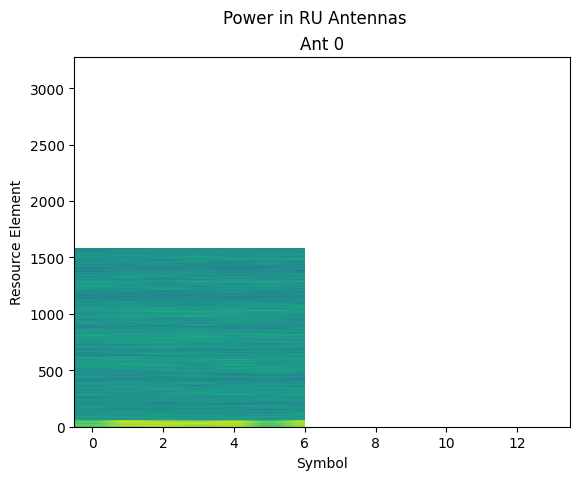

In [20]:
fig, axs = plt.subplots(1)
axs.imshow(10*np.log10(np.abs(rx_slot[:, :, 0]**2)), aspect='auto')
# axs.imshow(abs(rx_slot[:, :, 0]**2), aspect='auto')
axs.set_ylim([0, 273 * 12])
axs.set_title('Ant ' + str(0))
axs.set(xlabel='Symbol', ylabel='Resource Element')
axs.label_outer()
fig.suptitle('Power in RU Antennas') 
plt.show(fig)

In [7]:
print(fapi)

TsTaiNs                                              2025-04-07 17:01:45.056000
TsSwNs                                            2025-04-07 17:01:45.056972945
SFN                                                                         989
Slot                                                                         12
nUEs                                                                          1
pduBitmap                                                                     1
rnti                                                                      19122
BWPSize                                                                      -1
BWPStart                                                                     -1
SubcarrierSpacing                                                             1
CyclicPrefix                                                                  0
targetCodeRate                                                             5170
qamModOrder                             

In [8]:
rx = rx_slot[0 : 133 * 12, : 6, 0]

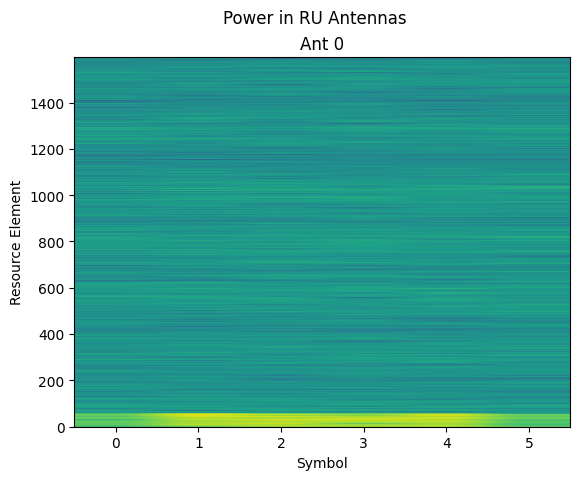

In [9]:
fig, axs = plt.subplots(1)
axs.imshow(10*np.log10(np.abs(rx**2)), aspect='auto')
# axs.imshow(abs(rx_slot[:, :, 0]**2), aspect='auto')
axs.set_ylim([0, 133 * 12])
axs.set_title('Ant ' + str(0))
axs.set(xlabel='Symbol', ylabel='Resource Element')
axs.label_outer()
fig.suptitle('Power in RU Antennas') 
plt.show(fig)

In [10]:
print(rx.shape)
rx_avg = np.mean(rx, axis=1)
print(rx_avg.shape)
rx_fft = np.fft.fft(rx_avg)
print(rx_fft.shape)

(1596, 6)
(1596,)
(1596,)


In [11]:
num_subcarriers = 1596  # N_subcarriers, e.g., from rx.shape[0]
subcarrier_spacing = 30  # F_ss in kHz (example value, adjust as needed)
delay_spread = 1e-6  # τ_RMS in seconds (example RMS delay spread, e.g., 1 µs)

# Step 1: Calculate delay sampling period (T_delay)
t_delay = 1 / (num_subcarriers * subcarrier_spacing * 1e3)  # F_ss from kHz to Hz

# Step 2: RMS delay spread in samples
rms_tau_samples = delay_spread / t_delay

# Step 3: Maximum truncation factor
max_truncation_factor = np.floor(num_subcarriers / rms_tau_samples)

# Step 4: Set truncation factor and compute max_delay
truncation_factor = 10
max_delay = round((delay_spread / t_delay) * truncation_factor / 2) * 2  # Even number
max_delay = 28  # Hard-coded override (as in your MATLAB code)
print(f"max_delay: {max_delay}")

# Step 5: Compute 2D FFT of the channel estimate
hdft2 = np.fft.fft2(rx)  # Shape remains (1596, 6)

# Step 6: Calculate truncation indices
n_sub = num_subcarriers  # Total subcarriers
mid_point = np.floor(n_sub / 2).astype(int)
lower_edge = int(mid_point - (n_sub - max_delay) / 2 + 1)
upper_edge = int(mid_point + (n_sub - max_delay) / 2)
print(f"lower_edge: {lower_edge}, upper_edge: {upper_edge}")

max_delay: 28
lower_edge: 15, upper_edge: 1582


In [12]:
# Step 7: Truncate the subcarrier dimension
# Indices to keep: [0:lower_edge-1] and [upper_edge+1:end]
keep_indices = np.concatenate((np.arange(0, lower_edge-1), np.arange(upper_edge+1, n_sub)))
htemp = hdft2[keep_indices, :]  # Shape becomes (1568, 6) if max_delay = 28
print(f"htemp shape: {htemp.shape}")
print(keep_indices)

htemp shape: (27, 6)
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595]


In [13]:
# Step 8: Apply 2D inverse FFT to get back to subcarrier-Tx antenna domain
htrunc = np.fft.ifft2(htemp)  # Shape remains (1568, 6)
print(f"htrunc shape: {htrunc.shape}")

htrunc shape: (27, 6)


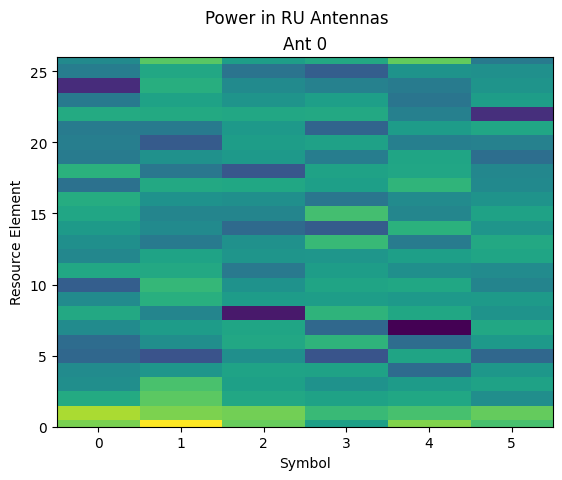

In [14]:
fig, axs = plt.subplots(1)
axs.imshow(10*np.log10(np.abs(htrunc**2)), aspect='auto')
# axs.imshow(abs(rx_slot[:, :, 0]**2), aspect='auto')
axs.set_ylim([0, 26])
axs.set_title('Ant ' + str(0))
axs.set(xlabel='Symbol', ylabel='Resource Element')
axs.label_outer()
fig.suptitle('Power in RU Antennas') 
plt.show(fig)